In [2]:
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import  InteractiveShell
InteractiveShell.ast_node_interactivity='all'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data

In [3]:
#http://files.grouplens.org/datasets/movielens/ml-1m.zip 
path='./data/ml-1m/'

In [4]:
unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
mnames = ['movie_id', 'title', 'genres']

users = pd.read_csv(path+'users.dat', sep='::', header=None, names=unames,engine='python',encoding='ISO-8859-1')
ratings = pd.read_table(path+'ratings.dat', sep='::', header=None, names=rnames, engine='python')
movies = pd.read_table(path+'movies.dat', sep='::', header=None, names=mnames, engine='python',encoding='ISO-8859-1')
#encoding='ISO-8859-1'
#解决‘utf-8‘ codec can‘t decode byte 0xe9 in position 3114: invalid continuation byte 错误

users.head()
ratings.head()
movies.head()

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [80]:
#合并数据
df_test = pd.merge(ratings, users, on='user_id')
df_test.head()

df = pd.merge(pd.merge(ratings, users, on='user_id'), movies, on='movie_id')
df.head()
df.shape

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip
0,1,1193,5,978300760,F,1,10,48067
1,1,661,3,978302109,F,1,10,48067
2,1,914,3,978301968,F,1,10,48067
3,1,3408,4,978300275,F,1,10,48067
4,1,2355,5,978824291,F,1,10,48067


,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama


(1000209, 10)

In [81]:
df['rating'].value_counts()

4    348971
3    261197
5    226310
2    107557
1     56174
Name: rating, dtype: int64

In [82]:
#构造2分类数据集,去掉中间的评价3
df=df[df['rating']!=3]
df.shape

(739012, 10)

In [83]:
#数据量比较大，单纯为了验证FM的效果，这里挑选有20～35次打分的movie_id
movie_group=df.groupby('movie_id').size()
print(type(movie_group))#movie_group是一个pd.Series类型数据

#print(pd.Series(movie_group)==movie_group)
movie_list=pd.Series(movie_group).where(lambda x : (20<x)&(x<35)).dropna().index.values
print(type(movie_list))
df=df[df['movie_id'].isin(movie_list)]

#这里挑选有>20次打分行为的user_id
user_group=df.groupby('user_id').size() #user_group也是一个pd.Series类型数据
user_list=pd.Series(user_group).where(lambda x : x>20).dropna().index.values

df=df[df['user_id'].isin(user_list)]
df.shape

df['user_id'].nunique(), df['movie_id'].nunique() #一共37个人，评分的总电影数是317部

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


(1251, 10)

(37, 317)

In [84]:
df.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
169417,889,498,2,975254346,M,45,20,10024,Mr. Jones (1993),Drama|Romance
169419,1150,498,1,974875561,F,25,20,75226,Mr. Jones (1993),Drama|Romance
169421,1448,498,4,976552318,F,25,3,17522,Mr. Jones (1993),Drama|Romance
169443,4169,498,2,976588339,M,50,0,66048,Mr. Jones (1993),Drama|Romance
169455,5812,498,2,1041034564,F,25,7,92120,Mr. Jones (1993),Drama|Romance


### 复习lambda函数和map函数

In [96]:
df['rating']=df['rating'].map(lambda x: -1 if x>3 else 1) #1,2是label=1  4,5是label=0

# Processing

In [86]:
#异常处理
df[['age']].describe([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.99]).T #age是被分段后的，没有异常值

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,99%,max
age,1251.0,30.801759,10.550785,1.0,1.0,18.0,18.0,25.0,25.0,35.0,50.0,50.0,50.0


对连续实数型特征采取分桶处理变为类别标签

 Age is chosen from the following ranges:

 1:  "Under 18"
 
 18:  "18-24"
 
 25:  "25-34"
 
 35:  "35-44"
 
 45:  "45-49"
 
 50:  "50-55"
 
 56:  "56+"

In [87]:
#时间处理
# df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
# df['date'] = df['timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1251 entries, 169417 to 999103
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     1251 non-null   int64 
 1   movie_id    1251 non-null   int64 
 2   rating      1251 non-null   int64 
 3   timestamp   1251 non-null   int64 
 4   gender      1251 non-null   object
 5   age         1251 non-null   int64 
 6   occupation  1251 non-null   int64 
 7   zip         1251 non-null   object
 8   title       1251 non-null   object
 9   genres      1251 non-null   object
dtypes: int64(6), object(4)
memory usage: 107.5+ KB


In [89]:
#one-hot encoder
from sklearn.preprocessing import OneHotEncoder

columns=['user_id', 'movie_id']

for i in columns:
    get_dummy_feature=pd.get_dummies(df[i])
    df=pd.concat([df, get_dummy_feature],axis=1)
    df=df.drop(i, axis=1)

df.head()

,rating,timestamp,gender,age,occupation,zip,title,genres,195,752,850,889,1069,1150,1181,1242,1266,1448,1470,1680,1698,1733,1941,2106,2665,2909,3032,3224,3391,3476,3526,3539,3610,3829,4161,4169,4227,4277,4344,4510,4647,5074,5111,5795,5812,27,38,40,54,55,77,83,99,103,113,121,149,179,182,201,202,211,214,220,238,240,263,268,269,278,294,297,301,304,320,324,335,341,343,347,384,386,391,409,418,422,433,443,452,453,460,463,470,472,476,488,495,496,498,499,510,568,571,583,600,602,619,621,656,665,669,704,705,710,711,718,722,731,746,760,806,808,813,824,840,841,846,862,869,875,885,956,957,964,970,984,990,1044,1053,1068,1112,1113,1119,1123,1151,1169,1310,1312,1317,1322,1325,1329,1331,1413,1415,1417,1428,1439,1447,1463,1472,1473,1489,1490,1507,1508,1529,1547,1551,1563,1564,1585,1596,1602,1609,1650,1668,1669,1677,1695,1696,1755,1771,1791,1798,1809,1812,1826,1829,1844,1854,1859,1867,1869,1896,1902,1910,1922,1926,1932,2007,2031,2032,2044,2045,2049,2103,2104,2131,2179,2190,2205,2237,2284,2286,2307,2323,2341,2345,2400,2426,2449,2465,2477,2479,2481,2483,2493,2494,2523,2536,2537,2552,2566,2573,2579,2586,2593,2610,2620,2626,2630,2635,2638,2646,2653,2659,2663,2666,2681,2689,2704,2711,2744,2758,2766,2810,2812,2813,2835,2847,2849,2864,2876,2878,2884,2893,2938,2939,2977,2979,2982,2992,3002,3010,3014,3021,3073,3109,3124,3128,3132,3133,3143,3144,3158,3192,3218,3222,3223,3239,3276,3306,3311,3318,3329,3331,3338,3339,3343,3367,3389,3390,3395,3414,3434,3442,3446,3454,3496,3518,3520,3539,3540,3559,3569,3573,3586,3588,3597,3602,3605,3612,3620,3632,3659,3665,3667,3673,3674,3691,3711,3719,3731,3736,3739,3765,3780,3781,3782,3797,3805,3806,3816,3820,3838,3851,3855,3870,3884,3885,3886,3898,3900,3912,3913,3921,3922,3931,3938,3942,3951
169417,1,975254346,M,45,20,10024,Mr. Jones (1993),Drama|Romance,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
169419,1,974875561,F,25,20,75226,Mr. Jones (1993),Drama|Romance,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
169421,-1,976552318,F,25,3,17522,Mr. Jones (1993),Drama|Romance,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [90]:
df.shape

(1251, 362)

In [91]:
df=df.drop(['timestamp','gender','age','occupation','zip','title','genres'], axis=1) 
#这些特征可以进一步挖掘。这里都不要了，只保留one-hot特征
df.head()

,rating,195,752,850,889,1069,1150,1181,1242,1266,1448,1470,1680,1698,1733,1941,2106,2665,2909,3032,3224,3391,3476,3526,3539,3610,3829,4161,4169,4227,4277,4344,4510,4647,5074,5111,5795,5812,27,38,40,54,55,77,83,99,103,113,121,149,179,182,201,202,211,214,220,238,240,263,268,269,278,294,297,301,304,320,324,335,341,343,347,384,386,391,409,418,422,433,443,452,453,460,463,470,472,476,488,495,496,498,499,510,568,571,583,600,602,619,621,656,665,669,704,705,710,711,718,722,731,746,760,806,808,813,824,840,841,846,862,869,875,885,956,957,964,970,984,990,1044,1053,1068,1112,1113,1119,1123,1151,1169,1310,1312,1317,1322,1325,1329,1331,1413,1415,1417,1428,1439,1447,1463,1472,1473,1489,1490,1507,1508,1529,1547,1551,1563,1564,1585,1596,1602,1609,1650,1668,1669,1677,1695,1696,1755,1771,1791,1798,1809,1812,1826,1829,1844,1854,1859,1867,1869,1896,1902,1910,1922,1926,1932,2007,2031,2032,2044,2045,2049,2103,2104,2131,2179,2190,2205,2237,2284,2286,2307,2323,2341,2345,2400,2426,2449,2465,2477,2479,2481,2483,2493,2494,2523,2536,2537,2552,2566,2573,2579,2586,2593,2610,2620,2626,2630,2635,2638,2646,2653,2659,2663,2666,2681,2689,2704,2711,2744,2758,2766,2810,2812,2813,2835,2847,2849,2864,2876,2878,2884,2893,2938,2939,2977,2979,2982,2992,3002,3010,3014,3021,3073,3109,3124,3128,3132,3133,3143,3144,3158,3192,3218,3222,3223,3239,3276,3306,3311,3318,3329,3331,3338,3339,3343,3367,3389,3390,3395,3414,3434,3442,3446,3454,3496,3518,3520,3539,3540,3559,3569,3573,3586,3588,3597,3602,3605,3612,3620,3632,3659,3665,3667,3673,3674,3691,3711,3719,3731,3736,3739,3765,3780,3781,3782,3797,3805,3806,3816,3820,3838,3851,3855,3870,3884,3885,3886,3898,3900,3912,3913,3921,3922,3931,3938,3942,3951
169417,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
169419,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
169421,-1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
169443,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [92]:
df.head()
df.shape

,rating,195,752,850,889,1069,1150,1181,1242,1266,1448,1470,1680,1698,1733,1941,2106,2665,2909,3032,3224,3391,3476,3526,3539,3610,3829,4161,4169,4227,4277,4344,4510,4647,5074,5111,5795,5812,27,38,40,54,55,77,83,99,103,113,121,149,179,182,201,202,211,214,220,238,240,263,268,269,278,294,297,301,304,320,324,335,341,343,347,384,386,391,409,418,422,433,443,452,453,460,463,470,472,476,488,495,496,498,499,510,568,571,583,600,602,619,621,656,665,669,704,705,710,711,718,722,731,746,760,806,808,813,824,840,841,846,862,869,875,885,956,957,964,970,984,990,1044,1053,1068,1112,1113,1119,1123,1151,1169,1310,1312,1317,1322,1325,1329,1331,1413,1415,1417,1428,1439,1447,1463,1472,1473,1489,1490,1507,1508,1529,1547,1551,1563,1564,1585,1596,1602,1609,1650,1668,1669,1677,1695,1696,1755,1771,1791,1798,1809,1812,1826,1829,1844,1854,1859,1867,1869,1896,1902,1910,1922,1926,1932,2007,2031,2032,2044,2045,2049,2103,2104,2131,2179,2190,2205,2237,2284,2286,2307,2323,2341,2345,2400,2426,2449,2465,2477,2479,2481,2483,2493,2494,2523,2536,2537,2552,2566,2573,2579,2586,2593,2610,2620,2626,2630,2635,2638,2646,2653,2659,2663,2666,2681,2689,2704,2711,2744,2758,2766,2810,2812,2813,2835,2847,2849,2864,2876,2878,2884,2893,2938,2939,2977,2979,2982,2992,3002,3010,3014,3021,3073,3109,3124,3128,3132,3133,3143,3144,3158,3192,3218,3222,3223,3239,3276,3306,3311,3318,3329,3331,3338,3339,3343,3367,3389,3390,3395,3414,3434,3442,3446,3454,3496,3518,3520,3539,3540,3559,3569,3573,3586,3588,3597,3602,3605,3612,3620,3632,3659,3665,3667,3673,3674,3691,3711,3719,3731,3736,3739,3765,3780,3781,3782,3797,3805,3806,3816,3820,3838,3851,3855,3870,3884,3885,3886,3898,3900,3912,3913,3921,3922,3931,3938,3942,3951
169417,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
169419,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
169421,-1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
169443,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

(1251, 355)

In [94]:
from sklearn.model_selection import train_test_split

X=df.drop('rating', axis=1)
Y=df['rating']

X_train,X_val,Y_train,Y_val=train_test_split(X, Y, test_size=0.25, random_state=532)
X_train.shape, X_val.shape

((938, 354), (313, 354))

In [97]:
Y.value_counts()  

 1    635
-1    616
Name: rating, dtype: int64

# FM model

特别注意，这里logit_loss和常见的二分类损失BCE_loss的形式有所不同，原因在于这里标签取值为1，-1。而BCE_loss的标签取值为1，0
经过推导发现其外层偏导最后是一样的(前者y取1，-1；后者y取1，0）

In [102]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logit(y, y_hat):     #对每一个样本计算损失
    return np.log(1 + np.exp(-y * y_hat))

def df_logit(y, y_hat):  #logit关于y_hat求导
    return sigmoid(-y * y_hat) * (-y)


推导可以参考：https://tech.meituan.com/2016/03/03/deep-understanding-of-ffm-principles-and-practices.html

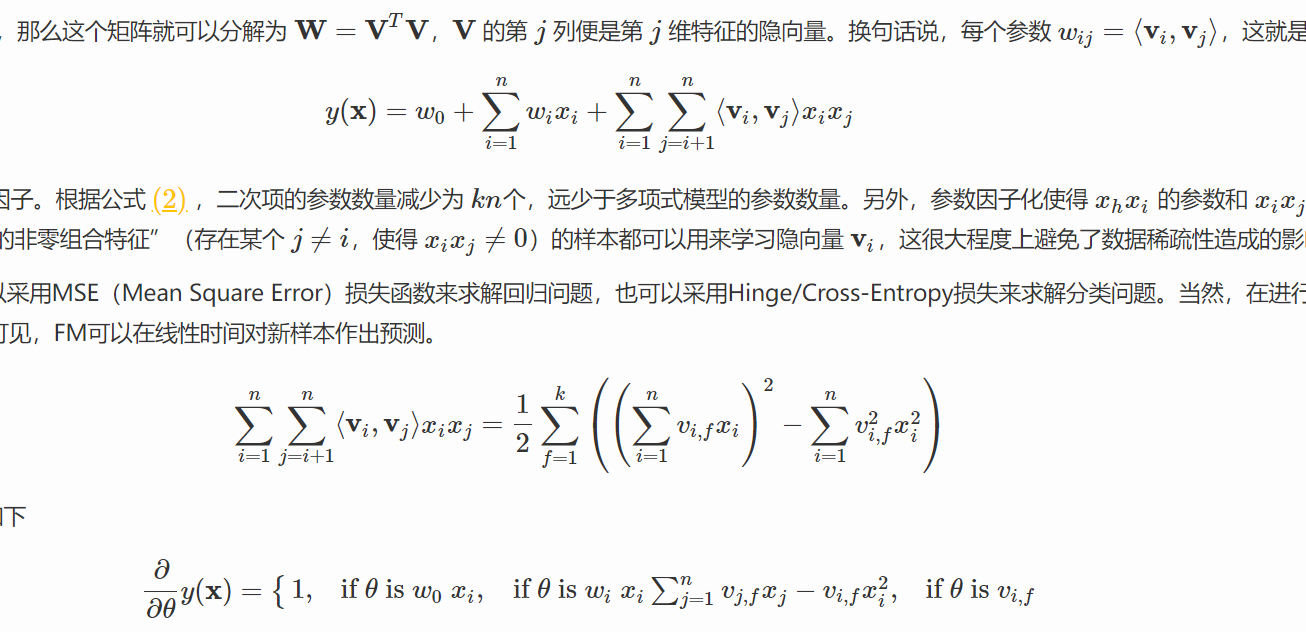

In [103]:
from sklearn.base import BaseEstimator,ClassifierMixin
from collections import Counter


class FactorizationMachine(BaseEstimator):
    def __init__(self, k=5, alpha=0.01, iternum=160):   #learning_rate改为alpha
        self.w0 = None 
        self.W = None 
        self.V = None 
        self.k = k 
        self.alpha = alpha
        self.iternum = iternum
        
        
    def _FM(self, Xi):
        interaction = np.sum((Xi.dot(self.V)) ** 2 - (Xi ** 2).dot(self.V ** 2)) 
        y_hat = self.w0 + Xi.dot(self.W) + interaction / 2  
        return y_hat[0]
        
        
    def _FM_SGD(self, X, y):
        m, n = np.shape(X) 
        #初始化参数
        self.w0 = 0
        self.W = np.random.uniform(size=(n, 1))
        self.V = np.random.uniform(size=(n, self.k)) #Vj是第j个特征的隐向量  Vjf是第j个特征的隐向量表示中的第f维
        
        for it in range(self.iternum):
            total_loss = 0  
            for i in range(m):  # 遍历训练集
                y_hat = self._FM(Xi=X[i])  #X[i]是第i个样本  X[i,j]是第i个样本的第j个特征

                total_loss += logit(y=y[i], y_hat=y_hat)  # 计算logit损失函数值
                dloss = df_logit(y=y[i], y_hat=y_hat)  # 计算logit损失函数的外层偏导

                dloss_w0 = dloss * 1   # 公式中的w0求导，计算复杂度O(1)
                self.w0 = self.w0 - self.alpha * dloss_w0 

                for j in range(n): 
                    if X[i, j] != 0:
                        dloss_Wj = dloss * X[i, j]  # 公式中的wi求导，计算复杂度O(n)
                        self.W[j] = self.W[j] - self.alpha * dloss_Wj 
                        for f in range(self.k):  # 公式中的vif求导，计算复杂度O(kn)
                            dloss_Vjf = dloss * (X[i, j] * (X[i].dot(self.V[:, f])) - self.V[j, f] * X[i, j] ** 2)
                            self.V[j, f] = self.V[j, f] - self.alpha * dloss_Vjf 

            if it %20==0:
                print('iter={}, loss={:.4f}'.format(it, total_loss / m))

        return self
    
    
    def _FM_predict(self, X):
        predicts, threshold = [], 0.5  # sigmoid阈值设置
        for i in range(X.shape[0]):  # 遍历测试集
            y_hat = self._FM(Xi=X[i])  # FM的模型方程 
            predicts.append(-1 if sigmoid(y_hat) < threshold else 1) 
        return np.array(predicts)        
        
        
    def fit(self, X, y):              #更新参数，返回训练好的对象（模型实例）
        if isinstance(X, pd.DataFrame):
            X = np.array(X)
            y = np.array(y)
            
        return self._FM_SGD(X, y)

    
    def predict(self, X):        #返回预测值，即-1或1
        if isinstance(X, pd.DataFrame):
            X = np.array(X)
        
        return self._FM_predict(X)
    
    
    def predict_proba(self, X):  #返回概率值
        pass
    

# Train & Predict

In [104]:
from sklearn.metrics import roc_auc_score, confusion_matrix

In [105]:
%%time
model=FactorizationMachine(k=10, alpha=0.001, iternum=160)
model.fit(X_train, Y_train)

iter=0, loss=1.6026
iter=20, loss=0.5674
iter=40, loss=0.5019
iter=60, loss=0.4629
iter=80, loss=0.4360
iter=100, loss=0.4155
iter=120, loss=0.3987
iter=140, loss=0.3844
CPU times: total: 1min 52s
Wall time: 1min 52s


FactorizationMachine(alpha=0.001, k=10)

In [106]:
y_pred=model.predict(X_train)

print('训练集roc: {:.2%}'.format(roc_auc_score(Y_train.values, y_pred)))
print('混淆矩阵: \n',confusion_matrix(Y_train.values, y_pred))

训练集roc: 84.65%
混淆矩阵: 
 [[388  70]
 [ 74 406]]


In [107]:
y_pred=model.predict(X_val)

print('验证集roc: {:.2%}'.format(roc_auc_score(Y_val.values, y_pred)))
print('混淆矩阵: \n',confusion_matrix(Y_val.values, y_pred))

验证集roc: 72.18%
混淆矩阵: 
 [[118  40]
 [ 47 108]]


In [111]:
model.V.shape

(354, 10)